# Gradient Boosting

### Overview

Our goal is to find a function $F^*(\mathbf{x})$ that maps $x$ to $y$ such that loss function $\Psi(y, F(\mathbf{x}))$ is minimized over the joint distribution of all $(y, x)$ values

$$F^*(\mathbf{x}) = \arg \min_{F(\mathbf{x})} E_{y, \mathbf{x}} \, \Psi(y, F(\mathbf{x}))$$


**Boosting** approximates $F^*(\mathbf{x})$ with an additive expansion with base learner $h(\mathbf{x}; \mathbf{a}_m)$ of the form
$$F(\mathbf{x}) = \sum_{m=0}^{M} \beta_m h(\mathbf{x}; \mathbf{a}_m)$$
where the base learners are usually chosen to be simple functions of $x$ with parameters $a=\{a_1, a_2, ...\}$. 

The expansion coefficients $\{\beta_m\}_0^M$ and the parameters $\{a_m\}_0^M$ are jointly fit (/trained/chosen) to the training data in a forward "stage-wise" manner. We start with an initial guess $F_0(x)$, and then for stages $m=1,2,...,M$ we find $\beta_m$, $a_m$ such that the loss between $y$ and $F_m(x)$ is minimized, 
  $$(\beta_m, a_m) = \arg \min_{\beta, a} \sum_{i=1}^{N} \Psi(y_i, F_{m-1}(x)+\beta h(x_i;a))$$
and $$F_m(x)=F_{m-1}(x)+\beta_mh(x;a_m)$$.

**Gradient Boosting** approximately solves for $\beta_m$ and $a_m$ with a two step procedure.

First, the base learner is fit by least squares 
    $$a_m = \arg \min_{a,p} \sum_{i=1}^{N}[\~y_{im}-ph(x_i;a)]^2$$
to the current "pseudo"-residuals (i.e. negative gradient of the loss w.r.t true $y_i$ and current predicted value $F_{m-1}(x_i)$)
    $$\~y_{im} = - [\frac{\partial \Psi(y_i, F(x_i))}{\partial F(x_i)}]_{F(x)=F_{m-1}(x)}$$

Second, given the base learner $h(x;a_m)$, the optimal value of the coefficient $\beta_m$ is determined (i.e. by choosing it such that minimizes the "total" loss w.r.t the true $y$ and new predicted value $F_m(x)$)
    $$\beta_m = \arg \min_\beta \sum_{i=1}^{N} \Psi(y_i, F_{m-1}(x_i)+\beta h(x_i;a_m))$$

**Gradient Tree Boosting** specializes this approach to the case where the base learner $h(x;a)$ is an L-terminal node regression tree.

At each iteration $m$, (*first step*) a regression tree is fitted to the current pseudo-residuals using a top-down "best-first" manner with a least-squares splitting criterion. It will partition the $x$-space into L-disjoint regions $\{R_{lm}\}_{l=1}^L$ and predicts a separate constant value in each one (region)
    $$h(x; \{R_{lm}\}_1^L) = \sum_{l=1}^L \bar y_{lm} \mathbb{1}_{x \in R_{lm}}$$
Here the constant value $\bar y = {mean}_{x_i \in R_{lm}} (\~y_{im})$ is the mean of pseudo-residuals in each region $R_{lm}$.
The parameters ($a_m$) of this base learner are the splitting variables and corresponding split points defining the tree, which in turn define the corresponding regions $\{R_{lm}\}_1^L$ of the partition at the $m \text{th}$ iteration. 

Then (*second step*), with the regression tree defined (with $\{R_{lm}\}_1^L$ defined), the coefficient $\beta_m$ can be solved separately within each region $R_{lm}$. Because the tree predicts a constant value within each region, the solution to $\beta_m$ reduces to a simple "location" estimate based on the criterion of the loss function
    $$\gamma_{lm} = \arg \min_\gamma \sum_{x_i \in R_{lm}} \Psi (y_i, F_{m-1}(x_i)+\gamma)$$

The current approximation is then separately updated in each corresponding region
    $$F_m(x) = F_{m-1}(x) + lr \cdot \gamma_{lm} \mathbb{1}_{x \in R_{lm}}$$
where $lr$ is the learning rate.

**Stochastic Gradient Boosting** draws a subsample of the training data at random (without replacement). This randomly selected subsample is then used to fit the base learner ($a_m$) and compute the model update for the current iteration ($\beta_m$).

Specifically, let $\{y_i, x_i\}_1^N$ be the entire training data sample and $\{\pi(i)\}_1^N$ be a random permutation of the integers $\{1,...,N\}$. Then, a random subsample of size $\~N < N$ is given by $\{y_{\pi(i)}, x_{\pi(i)}\}$.

**Our Implementation** takes the loss function of squared error and used stochastic gradient tree boosting for regression. By injecting the randomness of subsampling into the function estimation procedures, it would ideally be less prune to overfitting and more robust. By gradient boosting, it directly fits each base learner to the residual to the negative gradient of the loss thus converges faster and is more efficient. Nevertheless, it still suffers from the following disadvantages more or less -- 1. still potential overfitting, 2. higher computation cost dues to sequential training, 3. harder interpretability due to complex structures of trees invovled with stochastic subsampling.


**Stochastic Gradient Tree Boosting Pseudocode**
- Init input
    - learning_rate = 0.1
    - n_esitmators = 20                 
        - number of estimators (weak learners), same as the number of stages (M)
    - subsample = 0.5    
        - fraction for subsampling, if subsample<1, it is stochastic
    - min_samples = 1
        - the minimum number of samples to split for each tree
    - max_depth = 3                              
        - the maximum depth for each tree

- Train(X, Y)
    - start with an initial guess, say F(x) = mean(Y)
    - for m = 1 to M do:
        - X_batch, Y_batch = random_sampling(X, Y, fraction for subsampling (batch size))    # fraction < 1 leads to stochastic gradient boosting
        - Y_residual = negative gradient of loss between (true) Y and current F based on the batch
            - since we use (half of) sum of squared loss here
            - the gradient is thus F_m_batch-Y_batch
        - weak learner Tree $\{R_{lm}\}_1^L$ = L-terminal node tree fitting on (X_batch, Y_residual)
            - here $\{R_{lm}\}_1^L$ represents a set of L regions (leaf nodes) in stage m
            - $R_{lm}$ represents the l-th region (leaf node) in stage m
        - $\gamma_{lm} = arg min_{\gamma} \sum_{x-batch \in R_{lm}}$ loss(Y_batch, F(x)+$\gamma$)
            - that is, for each region l at stage m, find $\gamma$ such that it minimizes the loss for the new F(x) = F(x) + $\gamma$
            - which is the mean of the sample values at region l at stage m
        - update F(x) = F(x) + learning_rate * $\gamma * 1(x \in R_{lm})$
            - that is, F(x) = F(x) + learning_rate * new tree
            - note here we are multiplying the new tree with learning rate (different from how we obtain the best $\gamma$)
    - end for

- Predict(X)
    - Given input X, predict their values
    - which is the sum of initial guess and all the weak learners' prediction
    - where each weak learner's prediction is learning_rate * $\gamma * 1(x \in R_{lm})$

- Loss(X, Y)
    - Given input examples and their true values, calculate the squared loss

# Model

In [1]:
import numpy as np

# Calculate the sum of squared errors for the chosen parameter and splitting point
def squaErr(data, result, sequence, parameter, divide):
    left = []
    right = []

    for i in sequence:
        if data[i, parameter] < divide:
            left.append(i)
        else:
            right.append(i)

    if len(left) == 0 or len(right) == 0:  # If either subset is empty, return positive infinity
        return float('inf')

    c1 = np.mean(result[left])
    err1 = np.sum((result[left] - c1) ** 2)

    c2 = np.mean(result[right])
    err2 = np.sum((result[right] - c2) ** 2)

    return err1 + err2

# Determine the next splitting parameter and splitting point using histogram-based binning
def bestdivide(data, result, sequence, num_bins=256):
    min_para = None
    min_divide = None
    min_error = float('inf')
    
    for para in range(data.shape[1]):
        # Extract feature values for the current parameter
        feature_values = data[sequence, para]
        
        # Compute histogram bins
        bins = np.linspace(feature_values.min(), feature_values.max(), num_bins + 1)
        digitized = np.digitize(feature_values, bins) - 1  # Bin indices
        
        # Bin boundaries as possible split points
        bin_boundaries = (bins[:-1] + bins[1:]) / 2  # Midpoints between bin edges
        
        for boundary in bin_boundaries:
            error = squaErr(data, result, sequence, para, boundary)
            if error < min_error:
                min_error = error
                min_para = para
                min_divide = boundary

    return min_para, min_divide, min_error

class DecisionTreeRegressor:
    def __init__(self, min_samples=1, max_depth=3):
        self.min_samples = min_samples  # Minimum number of samples
        self.max_depth = max_depth  # Maximum depth
        self.root = None  # Root node of the decision tree

    class RegressionTree:
        def __init__(self, sequence, depth=0, max_depth=3):
            self.isLeaf = True  # Whether this node is a leaf
            self.left = None  # Left subtree
            self.right = None  # Right subtree
            self.output = None  # Prediction value for the current node
            self.sequence = sequence  # Indices of samples at the current node
            self.parameter = None  # Splitting feature
            self.divide = None  # Splitting point
            self.depth = depth  # Current depth
            self.max_depth = max_depth  # Maximum depth
            self.leaf_index = id(self)  # Unique identifier for the leaf

        # Grow from the current node
        def grow(self, data, result, minnum):
            if len(self.sequence) <= minnum or self.depth >= self.max_depth:  # Stop splitting if sample size is insufficient or maximum depth is reached
                self.output = np.mean(result[self.sequence])  # Set the prediction value as the mean
                return

            # Find the best splitting feature and splitting point
            parameter, divide, err = bestdivide(data, result, self.sequence)
            left = []
            right = []

            # Split data
            for i in self.sequence:
                if data[i, parameter] < divide:
                    left.append(i)
                else:
                    right.append(i)

            # Update node information
            self.parameter = parameter
            self.divide = divide
            self.isLeaf = False
            self.left = DecisionTreeRegressor.RegressionTree(left, depth=self.depth + 1, max_depth=self.max_depth)
            self.right = DecisionTreeRegressor.RegressionTree(right, depth=self.depth + 1, max_depth=self.max_depth)

            # Recursively grow left and right subtrees
            self.left.grow(data, result, minnum)
            self.right.grow(data, result, minnum)

        # Predict a single sample
        def predict_single(self, x):
            if self.isLeaf:  # If this is a leaf node, return the prediction value
                return self.output
            if x[self.parameter] < self.divide:  # If less than the splitting point, go to the left subtree
                return self.left.predict_single(x)
            else:  # Otherwise, go to the right subtree
                return self.right.predict_single(x)
            
        # Predict leaf index for a single sample
        def predict_leaf_index_single(self, x):
            if self.isLeaf:  # If this is a leaf node, return the leaf index
                return self.leaf_index
            if x[self.parameter] < self.divide:  # If less than the splitting point, go to the left subtree
                return self.left.predict_leaf_index_single(x)
            else:  # Otherwise, go to the right subtree
                return self.right.predict_leaf_index_single(x)

    # Fit the training data
    def fit(self, X, y):
        self.root = self.RegressionTree(sequence=range(len(y)), max_depth=self.max_depth)
        self.root.grow(X, y, self.min_samples)

    # Predict the input data
    def predict(self, X):
        return np.array([self.root.predict_single(sample) for sample in X])
    
    # Predict leaf indices for the input data
    def predict_leaf_indices(self, X):
        return np.array([self.root.predict_leaf_index_single(sample) for sample in X])


In [2]:
import numpy as np
import math

def squared_loss(predict, target):
    '''
    Calculates the sum of squared loss between predicted values and true values

    :param predict: a 1-d numpy array containing the predicted values
    :param target: a 1-d numpy array containing the true values
    :return loss: squared loss
    '''
    loss = 0.5*np.sum(np.power(predict-target, 2))

    return loss

class StochasticGradientBoosting:
    def __init__(self, learning_rate=0.1, n_estimators=20, subsample=0.5, min_samples=1, max_depth=3):
        """
        :param learning_rate: learning rate, default 0.1
        :param n_estimators: number of weak learners, default 20 (same as M)
        :param subsample: fraction for subsampling, default 0.5
        :param min_samples: the minimum number of samples for each tree, default 1
        :param max_depth: the maximum depth for each tree (weak learner), default 3
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.subsample = subsample
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.models = []    # models is a list of weak learners (decision trees)
        self.gammas = []    # gammas is a list of lists of gamma value for each tree's region
        self.initial_prediction = None  # will be initialized in train to be mean
        self.leaf_indices_dict = []     # this will store a list of leaf indices for each tree

    def train(self, X, Y):
        # initial guess F_m=mean(Y)
        self.initial_prediction = np.mean(Y)
        F_m = np.full(Y.shape, self.initial_prediction) # current F

        for m in range(self.n_estimators):
            # Random sampling for stochastic gradient boosting
            batch_size = math.floor(self.subsample*len(Y))
            indices = np.random.choice(len(Y), batch_size, replace=False)
            X_batch, Y_batch = X[indices], Y[indices]

            # Calculate residuals (negative gradient of the loss)
            residuals = Y_batch - F_m[indices]

            # Train a weak learner on the residuals
            weak_learner = DecisionTreeRegressor(min_samples=self.min_samples, max_depth=self.max_depth)
            weak_learner.fit(X_batch, residuals)
            self.models.append(weak_learner)

            # Update F_m for all samples
            leaf_indices = weak_learner.predict_leaf_indices(X)
            unique_leaves = np.unique(leaf_indices)
            self.leaf_indices_dict.append(unique_leaves)
            gamma_m = []    # the gammas for m'th tree, where each region (leaf) will have a corresponding gamma value
            for leaf_index in unique_leaves:
                region_mask = (leaf_indices == leaf_index)
                gamma = np.mean(residuals[region_mask[indices]])
                gamma_m.append(gamma)
                F_m[region_mask] += self.learning_rate * gamma
            self.gammas.append(gamma_m)

    def predict(self, X):
        # Start with the initial prediction
        F_m = np.full(X.shape[0], self.initial_prediction)

        # Add contributions from each weak learner
        for m, model in enumerate(self.models):
            leaf_indices = model.predict_leaf_indices(X)
            unique_leaves = self.leaf_indices_dict[m]
            for i, leaf_index in enumerate(unique_leaves):
                region_mask = (leaf_indices == leaf_index)
                F_m[region_mask] += self.learning_rate * self.gammas[m][i]

        return F_m

    def loss(self, X, Y):
        """calculates the squared loss given inputs and their true values"""
        pred = self.predict(X)
        loss = squared_loss(pred, Y)

        return loss

## **Check Model**

Testing individual functions with dummy data.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
import numpy as np
import pytest


X = np.array([[1], [2], [3], [4], [5]])
Y = np.array([1.1, 2.0, 2.9, 4.1, 5.0])

model = StochasticGradientBoosting(
    learning_rate=0.1, 
    n_estimators=10, 
    subsample=0.8, 
    min_samples=1, 
    max_depth=2
)

# Train the model
model.train(X, Y)

# Test initial prediction
assert np.isclose(model.initial_prediction, np.mean(Y)), "Initial prediction should be the mean of Y"

# Test the number of weak learners (decision trees) trained
assert len(model.models) == model.n_estimators, "Number of models should match n_estimators"

# Test that gammas have been computed for each tree
assert len(model.gammas) == model.n_estimators, "Gammas should be computed for each tree"
for gamma_list in model.gammas:
    assert len(gamma_list) > 0, "Each tree should have at least one gamma value"

# Test predictions
predictions = model.predict(X)
assert predictions.shape == Y.shape, "Predictions should have the same shape as Y"

# Test if predictions improve with training
assert np.mean((predictions - Y) ** 2) < np.mean((np.mean(Y) - Y) ** 2), \
    "Predictions should reduce mean squared error compared to baseline"

# Test loss 
loss = model.loss(X, Y)
assert loss >= 0, "Loss should be non-negative"
expected_loss = 0.5 * np.sum(np.power(predictions - Y, 2)) # or mse?
assert np.isclose(loss, expected_loss), "Loss should match the defined loss function (scaled SSE)"


Testing against sklearn on dummy data.

model loss: 0.5607269200106376
sklearn model loss: 0.38524973632554715
model vs sklearn model: 0.1464148251085622


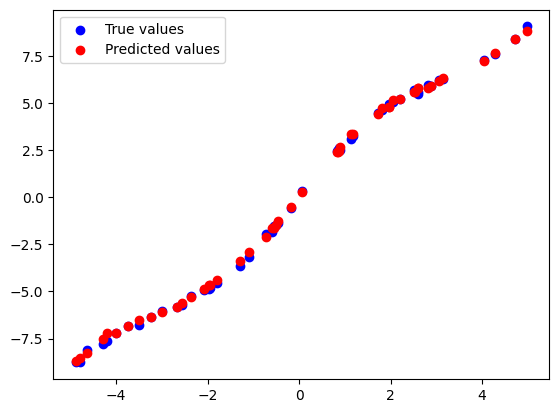

In [4]:
# toy test for the whole model -- GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)
# set some param for testing
learning_rate=0.1
n_estimators=50     # generally, more estimators lead to better resutls
# subsample=0.5   # subsample of 1 achieves almost the same as sklearn, but subsample less than 1 causes some variation
subsample=1
min_samples=5
max_depth=3

def generate_synthetic_data(n_samples=100, noise=0.1):
    X = np.random.rand(n_samples, 1) * 10 - 5  # Random features between [-5, 5]
    Y = 2 * X.squeeze() + np.sin(X).squeeze() + np.random.randn(n_samples) * noise  # Linear + sine function + noise
    return X, Y

X_train, Y_train = generate_synthetic_data(n_samples=500)
X_test, Y_test = generate_synthetic_data(n_samples=50)

# Train the model
model = StochasticGradientBoosting(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples=min_samples, max_depth=max_depth)
model.train(X_train, Y_train)
predictions = model.predict(X_test)

# Also the sklearn model
sklearn_model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples, max_depth=max_depth)
sklearn_model.fit(X_train, Y_train)
sklearn_pred = sklearn_model.predict(X_test)
sklearn_loss = squared_loss(sklearn_pred, Y_test)

# print loss
print(f"model loss: {squared_loss(predictions, Y_test)}")
print(f"sklearn model loss: {squared_loss(sklearn_pred, Y_test)}")
print(f"model vs sklearn model: {squared_loss(predictions, sklearn_pred)}")

# Plot the results
import matplotlib.pyplot as plt
plt.scatter(X_test, Y_test, color='blue', label='True values')
plt.scatter(X_test, predictions, color='red', label='Predicted values')
plt.legend()
plt.show()


## **Main**

In [ ]:
# get a public dataset


# compare model result on the dataset with sklearn result on the same dataset
#X, Y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import os


def squared_loss(predictions, targets):
    """Custom squared loss calculation."""
    return np.mean((predictions - targets) ** 2)

def test_boosting_models(dataset, test_size=0.2):
    """
    Compares the performance of our StochasticGradientBoosting with sklearn's GradientBoostingRegressor on a given dataset.
    :param dataset: The path to the dataset
    :param test_size: The proportion of the dataset to include in the test split
    :return: None
    """
    # Check if the file exists
    if not os.path.exists(dataset):
        print(f"The file {dataset} does not exist")
        exit()

    # Load in the dataset
    data = np.loadtxt(dataset, skiprows=1)
    X, Y = data[:, 1:], data[:, 0]

    # Normalize the features
    X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    print('Running models on {} dataset'.format(dataset))
    
    #### StochasticGradientBoosting ######
    print("----- StochasticGradientBoosting -----")
    my_model = StochasticGradientBoosting(
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        min_samples=2,
        max_depth=3
    )
    #print(X_train.shape, Y_train.shape)
    my_model.train(X_train, Y_train)   # why is this taking so long
    print("hi")
    my_train_predictions = my_model.predict(X_train)
    my_test_predictions = my_model.predict(X_test)

    my_train_loss = squared_loss(my_train_predictions, Y_train)
    my_test_loss = squared_loss(my_test_predictions, Y_test)

    print("My Model Training Loss:", my_train_loss)
    print("My Model Testing Loss:", my_test_loss)
   
    #### sklearn GradientBoostingRegressor ######
    print("----- sklearn GradientBoostingRegressor -----")
    sklearn_model = GradientBoostingRegressor(
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        min_samples_split=2,
        max_depth=3,
        random_state=0
    )
    sklearn_model.fit(X_train, Y_train)
    sklearn_train_predictions = sklearn_model.predict(X_train)
    sklearn_test_predictions = sklearn_model.predict(X_test)

    sklearn_train_loss = squared_loss(sklearn_train_predictions, Y_train)
    sklearn_test_loss = squared_loss(sklearn_test_predictions, Y_test)

    print("Sklearn Model Training Loss:", sklearn_train_loss)
    print("Sklearn Model Testing Loss:", sklearn_test_loss)

    #### Compare results ######
    print("----- Comparison -----")
    print(f"Training Loss Difference: {my_train_loss - sklearn_train_loss:.4f}")
    print(f"Testing Loss Difference: {my_test_loss - sklearn_test_loss:.4f}")

# Set random seeds for reproducibility
np.random.seed(0)

test_boosting_models('wine.txt')


Running models on wine.txt dataset
----- StochasticGradientBoosting -----
hi
My Model Training Loss: 0.378544231509949
My Model Testing Loss: 0.5809187798022113
----- sklearn GradientBoostingRegressor -----
Sklearn Model Training Loss: 0.37438377629098263
Sklearn Model Testing Loss: 0.568075903436917
----- Comparison -----
Training Loss Difference: 0.0042
Testing Loss Difference: 0.0128
